In [ ]:
pip install scikeras

In [ ]:
pip install opencv-python

In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import splitfolders
import matplotlib.pyplot as plt
from skimage import transform, io
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import InceptionV3, ResNet152, InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score,roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV

import re
import cv2
from PIL import Image

In [2]:
df = pd.read_csv(r"C:\Users\n1109899\Downloads\aptos2019-blindness-detection\train.csv", delimiter=",")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
# Retriving the class list
class_list = df["diagnosis"].unique()
class_list = [int(item) for item in class_list if not np.isnan(item)]
class_list = sorted(class_list)
class_list

[0, 1, 2, 3, 4]

## Load and Split dataset

In [4]:
# specify image folder
image_folder = 'train_images'
extension = '.png'

In [5]:
# check for dublicates
df.duplicated().sum()

0

In [6]:
# get label df columns
df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [22]:
# order and load all images and labels into arrays
train_ = []
label_ = []
data = []
dims = 299
for image in df["id_code"]:
    image_file = cv2.imread(os.path.join(image_folder,image+extension))
    #image_file = cv2.resize(image_file,(dims,dims))
    idx = df["id_code"].tolist().index(image)
    label = df["diagnosis"][idx]
    
    train_.append(image_file)
    label_.append(label)

train_set = np.array(train_)
train_label = np.array(label_)

C:\Users\n1109899\AppData\Local\Temp/ipykernel_11312/182509564.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_set = np.array(train_)


In [46]:
X_train1,X_test,y_train1,y_test = train_test_split(train_set,train_label,test_size=0.2, shuffle = True, random_state=42)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size = 0.2, shuffle = True, random_state = True)

In [48]:
X_train.shape,X_test.shape, X_val.shape

((2343,), (733,), (586,))

In [49]:
y_train.shape,y_test.shape, y_val.shape

((2343,), (733,), (586,))

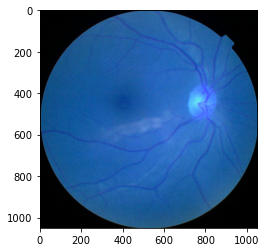

In [50]:
plt.imshow(X_val[76])

## Augment train set

In [51]:
def adjust_contrast(image):
    return tf.image.adjust_contrast(image,2)

def adjust_brightness(image):
    return tf.image.adjust_brightness(image,0.2)

def adjust_saturation(image):
    return tf.image.adjust_saturation(image,10)

def adjust_hue(image):
    return tf.image.adjust_hue(image,-0.1)

def adjust_flip(image):
    return tf.image.random_flip_left_right(image)

In [52]:
augmentations = [adjust_contrast,adjust_brightness,adjust_saturation,adjust_hue,adjust_flip]

In [53]:
def random_augmentation(data):
    augmented_images = []
    
    for index, image in enumerate(data):
        random_augmentation = random.choice(augmentations)
        aug_img = random_augmentation(image)
        
        index = index + 1
        
        if ((index % 2) == 0):
            aug_img = np.array(random_augmentation(image))
            augmented_images.append(aug_img)
        else:
            augmented_images.append(image)
    return augmented_images

In [54]:
X_train = random_augmentation(X_train) # This is a list for now

In [44]:
X_train = np.array(X_train)

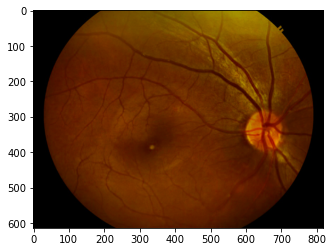

In [55]:
temp = cv2.cvtColor(X_train[45], cv2.COLOR_BGR2RGB)
plt.imshow(temp)
plt.show()

### Resize and Rescale

In [56]:
def resizeImages(images):
    resized_aug_images = []
    for img in images:
        img = cv2.resize(img,(299,299))

        resized_aug_images.append(img)
    return resized_aug_images

In [57]:
X_train = resizeImages(X_train)
X_train = np.array(X_train)

In [60]:
X_train.shape

(2343, 299, 299, 3)

In [61]:
X_val = resizeImages(X_val)
X_val = np.array(X_val)

In [62]:
X_test = resizeImages(X_test)
X_test = np.array(X_test)
X_test.shape

(733, 299, 299, 3)

In [64]:
# function to scale images
def scale(dataset):
    factor = 255.0
    dataset = dataset/factor
    return dataset

In [65]:
# scale images
X_train= scale(X_train)
X_val = scale(X_val)
X_test = scale(X_test)

## Evaluation functions

In [67]:
# Accuracy and Loss curves
def plot_acc_loss(model_history):
    train_acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']

    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']

    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()

In [68]:
# display confusion matrix heatmap
def confusion_heatmap(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(7,4), dpi=100)
    ax.set(title='Confusion Matrix for the InceptionV3 model')
    disp.plot(ax = ax)
    plt.show()

In [69]:
# calculate weighted_average specificity
def weighted_average_specificity(cm):
    num_classes = 5
    class_counts = []

    for class_label in range(num_classes):
        # Create  binary classification for the current class
        binary_test = [1 if label == class_label else 0 for label in y_test]
         # Count the number of samples for the current class
        class_counts.append(sum(binary_test))
    print(class_counts)   

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity = np.average(specificity, weights = class_counts)
    return specificity

In [70]:
# calculate macro_average specificity
def macro_average_specificity(cm):

    fp = cm.sum(axis=0) - np.diag(cm)  
    fn = cm.sum(axis=1) - np.diag(cm)
    tp = np.diag(cm)
    tn = cm.sum() - (fp + fn + tp)
    specificity = tn/(tn+fp) 

    specificity =np.mean(specificity)
    return specificity

In [71]:
# Calculate the micro-average AUC
def micro_average_auc(y_pred):
    
    micro_avg_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    return micro_avg_auc



In [72]:
# roc curve
def roc_plot(y_pred):

# Binarize actual test labels 
    y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))

    # Compute the ROC curve and AUC for the micro-average
    fpr, tpr, _ = roc_curve(y_test_cat.ravel(), y_pred.ravel())
   
    # Plot the micro-average ROC curve
    plt.figure(figsize=(6, 4))
    
    plt.plot(fpr, tpr, color='deeppink', linestyle='-', lw=1)         

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curve')
    plt.show()


## Model Development and Training

In [73]:
# function to build model
def build_model(pre_trained_network):
    base_model = pre_trained_network(weights = 'imagenet', include_top = False, input_shape = (dims,dims,colour_channel))
    
    for layers in base_model.layers:
        layers.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation = 'softmax'))
    print(model.summary())
    
    #compile model
    #specify optimizer, loss and earlytopping
    adam = tf.keras.optimizers.Adam(learning_rate = lr)
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    model.compile(optimizer = adam, loss = loss, metrics = METRICS)
    
    return model

In [74]:
colour_channel =3
epochs = 50
lr = 0.001
METRICS=['accuracy']
batch_size = 32
patience = 10
num_classes = 5
dropout = 0.5
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience)

### Build and train model 1 - Inception V3

In [75]:
InceptionV3_model = build_model(InceptionV3)

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 21813029 (83.21 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
None


In [77]:
InceptionV3_model_history = InceptionV3_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) , callbacks = [callback])
                                            

Epoch 1/50
74/74 [==============================] - 79s 1s/step - loss: 1.1462 - accuracy: 0.6018 - val_loss: 0.8335 - val_accuracy: 0.7048
Epoch 2/50
74/74 [==============================] - 77s 1s/step - loss: 0.8668 - accuracy: 0.6897 - val_loss: 0.7411 - val_accuracy: 0.7270
Epoch 3/50
74/74 [==============================] - 76s 1s/step - loss: 0.7654 - accuracy: 0.7209 - val_loss: 0.6832 - val_accuracy: 0.7406
Epoch 4/50
74/74 [==============================] - 77s 1s/step - loss: 0.7322 - accuracy: 0.7286 - val_loss: 0.6537 - val_accuracy: 0.7491
Epoch 5/50
74/74 [==============================] - 75s 1s/step - loss: 0.7015 - accuracy: 0.7345 - val_loss: 0.6452 - val_accuracy: 0.7594
Epoch 6/50
74/74 [==============================] - 75s 1s/step - loss: 0.6722 - accuracy: 0.7529 - val_loss: 0.6359 - val_accuracy: 0.7509
Epoch 7/50
74/74 [==============================] - 79s 1s/step - loss: 0.6470 - accuracy: 0.7516 - val_loss: 0.6058 - val_accuracy: 0.7662
Epoch 8/50
74/74 [==

In [78]:
# save model
InceptionV3_model.save('aug_unprocessed_InceptionV3_model1.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


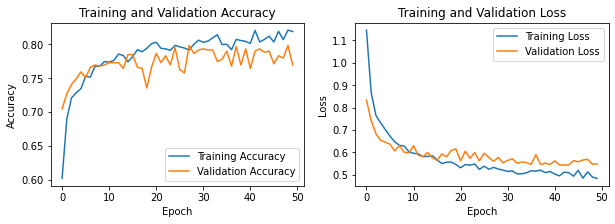

In [79]:
plot_acc_loss(InceptionV3_model_history)

### Evaluate Inception model 

In [80]:
# Predict on test set
inceptionv3_y_pred = InceptionV3_model.predict(X_test)

23/23 [==============================] - 19s 769ms/step


In [81]:
# Classification report
inceptionv3_y_pred_labels = np.argmax(inceptionv3_y_pred, axis=1)
print(classification_report(y_test, inceptionv3_y_pred_labels))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       351
           1       0.42      0.54      0.47        68
           2       0.68      0.72      0.70       213
           3       0.57      0.22      0.32        36
           4       0.38      0.22      0.27        65

    accuracy                           0.76       733
   macro avg       0.60      0.54      0.54       733
weighted avg       0.74      0.76      0.74       733



In [82]:
# Confusion matrix
inceptionv3_conf_matrix = confusion_matrix(y_test, inceptionv3_y_pred_labels)

inceptionv3_conf_matrix

array([[341,   8,   2,   0,   0],
       [ 12,  37,  16,   0,   3],
       [ 12,  32, 154,   2,  13],
       [  0,   5,  16,   8,   7],
       [  2,   6,  39,   4,  14]], dtype=int64)

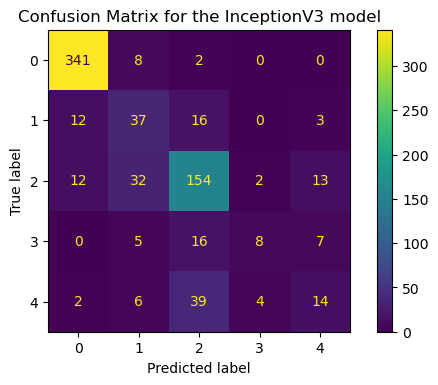

In [83]:
# confusion matrix
confusion_heatmap(inceptionv3_conf_matrix)

In [84]:
# weighted average specificity
inception_wa_specificity = weighted_average_specificity(inceptionv3_conf_matrix)
print(inception_wa_specificity)

[351, 68, 213, 36, 65]
0.9160232789241356


In [85]:
inception_ma_specificity = macro_average_specificity(inceptionv3_conf_matrix)
print(inception_ma_specificity)

0.9343642737930127


In [86]:
micro_avg_auc = micro_average_auc(inceptionv3_y_pred)
print("Micro-Average AUC:", micro_avg_auc)


Micro-Average AUC: 0.8994897408443279


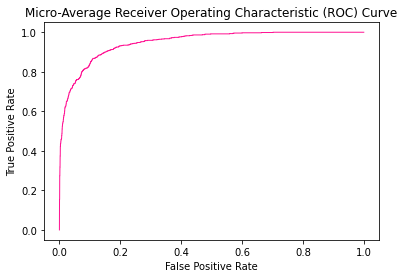

In [87]:
roc_plot(inceptionv3_y_pred)

## Build and train model 2 - ResNet152

In [88]:
# build and compile model
resnet152_model = build_model(ResNet152)

234698864/234698864 [==============================] - 9s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 10, 10, 2048)      58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 58381189 (222.71 MB)
Trainable params: 10245 (40.02 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________
None


In [89]:
# fit resnet model
resnet152_model_history = resnet152_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) ,shuffle= True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 334s 4s/step - loss: 1.6178 - accuracy: 0.4213 - val_loss: 1.2717 - val_accuracy: 0.4710
Epoch 2/50
74/74 [==============================] - 337s 5s/step - loss: 1.4135 - accuracy: 0.4622 - val_loss: 1.2436 - val_accuracy: 0.4710
Epoch 3/50
74/74 [==============================] - 322s 4s/step - loss: 1.3070 - accuracy: 0.5100 - val_loss: 1.1815 - val_accuracy: 0.5341
Epoch 4/50
74/74 [==============================] - 337s 5s/step - loss: 1.2822 - accuracy: 0.5288 - val_loss: 1.1458 - val_accuracy: 0.6655
Epoch 5/50
74/74 [==============================] - 354s 5s/step - loss: 1.2351 - accuracy: 0.5523 - val_loss: 1.1085 - val_accuracy: 0.5904
Epoch 6/50
74/74 [==============================] - 338s 5s/step - loss: 1.2068 - accuracy: 0.5625 - val_loss: 1.1417 - val_accuracy: 0.5444
Epoch 7/50
74/74 [==============================] - 332s 5s/step - loss: 1.1644 - accuracy: 0.5839 - val_loss: 1.1391 - val_accuracy: 0.5324
Epoch 8/50
74

In [90]:
# save model
resnet152_model.save('aug_unprocessed_ResNet152_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


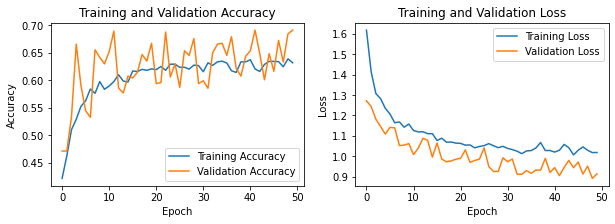

In [91]:
plot_acc_loss(resnet152_model_history)

### Evaluate ResNet152 model

In [92]:
# Predict on test set
resnet152_y_pred = resnet152_model.predict(X_test)

23/23 [==============================] - 86s 4s/step


In [93]:
# Classification report
resnet152_y_pred_labels = np.argmax(resnet152_y_pred, axis=1)
print(classification_report(y_test, resnet152_y_pred_labels))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88       351
           1       0.00      0.00      0.00        68
           2       0.55      0.89      0.68       213
           3       0.00      0.00      0.00        36
           4       0.00      0.00      0.00        65

    accuracy                           0.70       733
   macro avg       0.28      0.36      0.31       733
weighted avg       0.56      0.70      0.62       733



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [94]:
# Confusion matrix
resnet152_conf_matrix = confusion_matrix(y_test, resnet152_y_pred_labels)

print(resnet152_conf_matrix)

[[326   0  25   0   0]
 [ 14   0  54   0   0]
 [ 23   0 190   0   0]
 [ 11   0  25   0   0]
 [ 13   0  52   0   0]]


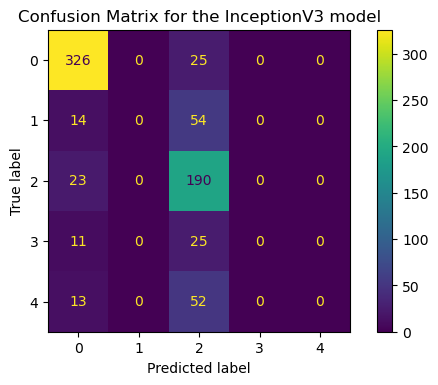

In [95]:
# confusion matrix heatmap
confusion_heatmap(resnet152_conf_matrix)

In [96]:
# weighted average specificity
resnet152_wa_specificity = weighted_average_specificity(resnet152_conf_matrix)
print(resnet152_wa_specificity)

[351, 68, 213, 36, 65]
0.8363577923330214


In [97]:
# macro avg specificity
resnet152_ma_specificity = macro_average_specificity(resnet152_conf_matrix)
print(resnet152_ma_specificity)

0.9080628272251309


In [98]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(resnet152_y_pred)
print("ResNet152 Micro-Average AUC:", micro_avg_auc)


ResNet152 Micro-Average AUC: 0.8217297076258493


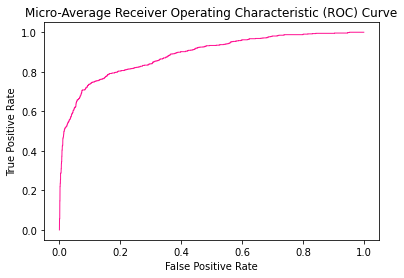

In [99]:
roc_plot(resnet152_y_pred)

## Build and train model 3 - InceptionResNetV2

In [100]:
# build anad compile model
inceptionResnet_model = build_model(InceptionResNetV2)

219055592/219055592 [==============================] - 7s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 8, 8, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_2  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 7685 (30.02 KB)
Non-trainable params: 54336736 (207.28 MB)
_______

In [101]:
# fit resnet model
inceptionResnet_model_history = inceptionResnet_model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data =(X_val, y_val) ,shuffle= True, callbacks = [callback])


Epoch 1/50
74/74 [==============================] - 214s 3s/step - loss: 1.2741 - accuracy: 0.5322 - val_loss: 0.9168 - val_accuracy: 0.6775
Epoch 2/50
74/74 [==============================] - 210s 3s/step - loss: 0.9654 - accuracy: 0.6633 - val_loss: 0.8078 - val_accuracy: 0.7082
Epoch 3/50
74/74 [==============================] - 215s 3s/step - loss: 0.8636 - accuracy: 0.6893 - val_loss: 0.7410 - val_accuracy: 0.7253
Epoch 4/50
74/74 [==============================] - 214s 3s/step - loss: 0.8014 - accuracy: 0.7123 - val_loss: 0.7163 - val_accuracy: 0.7577
Epoch 5/50
74/74 [==============================] - 217s 3s/step - loss: 0.7881 - accuracy: 0.7093 - val_loss: 0.6901 - val_accuracy: 0.7645
Epoch 6/50
74/74 [==============================] - 209s 3s/step - loss: 0.7575 - accuracy: 0.7213 - val_loss: 0.6634 - val_accuracy: 0.7645
Epoch 7/50
74/74 [==============================] - 220s 3s/step - loss: 0.7435 - accuracy: 0.7273 - val_loss: 0.6535 - val_accuracy: 0.7577
Epoch 8/50
74

In [102]:
# save model
inceptionResnet_model.save('aug_processed_inceptionResnet_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


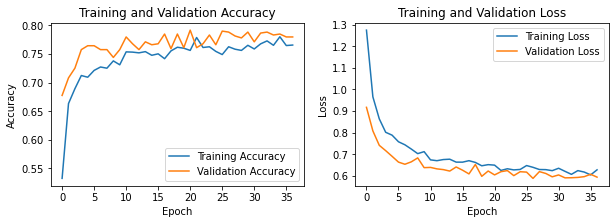

In [103]:
# plot loss and accuracy
plot_acc_loss(inceptionResnet_model_history)

### Evaluate InceptionResNetV2 model

In [104]:
# Predict on test set
inceptionResnet_y_pred = inceptionResnet_model.predict(X_test)

23/23 [==============================] - 60s 3s/step


In [105]:
# Classification report
inceptionResnet_y_pred_labels = np.argmax(inceptionResnet_y_pred, axis=1)
print(classification_report(y_test, inceptionResnet_y_pred_labels))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       351
           1       0.55      0.47      0.51        68
           2       0.66      0.81      0.73       213
           3       0.42      0.31      0.35        36
           4       0.42      0.08      0.13        65

    accuracy                           0.77       733
   macro avg       0.59      0.53      0.53       733
weighted avg       0.74      0.77      0.74       733



In [106]:
# Confusion matrix
inceptionResnet_conf_matrix = confusion_matrix(y_test, inceptionResnet_y_pred_labels)

print(inceptionResnet_conf_matrix)

[[342   5   4   0   0]
 [ 14  32  21   0   1]
 [ 12  16 173   7   5]
 [  1   1  22  11   1]
 [  5   4  43   8   5]]


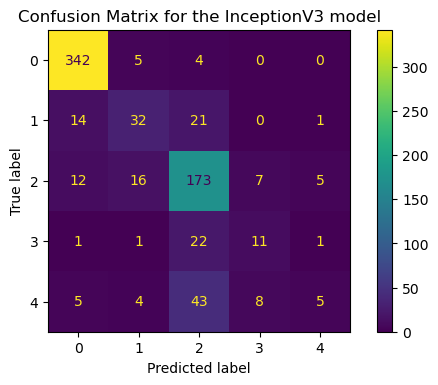

In [107]:
# confusion matrix heatmap
confusion_heatmap(inceptionResnet_conf_matrix)

In [108]:
# weighted average specificity
inceptionResnet_wa_specificity = weighted_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_wa_specificity)

[351, 68, 213, 36, 65]
0.9039794553319328


In [109]:
# macro avg specificity
inceptionResnet_ma_specificity = macro_average_specificity(inceptionResnet_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9344111707389651


In [110]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(inceptionResnet_y_pred)
print("InceptionResNet Micro-Average AUC:", micro_avg_auc)


InceptionResNet Micro-Average AUC: 0.9010572077515597


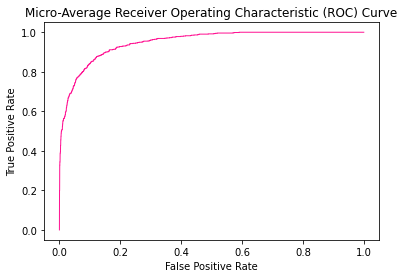

In [111]:
roc_plot(inceptionResnet_y_pred)

## Averaging

In [112]:
model1 = InceptionV3_model
model2 = resnet152_model
model3 = inceptionResnet_model

In [113]:
models = [model1, model2, model3]

In [114]:
preds = [model.predict(X_test) for model in models]

23/23 [==============================] - 60s 3s/step


In [115]:
pred = np.array(preds)

In [116]:
summed = np.sum(preds, axis=0)


In [117]:
mean_preds = np.mean(preds, axis = 0)

In [118]:
# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

In [119]:
print(classification_report(y_test, ensemble_prediction))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       351
           1       0.60      0.43      0.50        68
           2       0.64      0.89      0.74       213
           3       0.57      0.11      0.19        36
           4       0.62      0.08      0.14        65

    accuracy                           0.78       733
   macro avg       0.67      0.50      0.50       733
weighted avg       0.76      0.78      0.74       733



In [120]:
# Confusion matrix
ensemble_conf_matrix = confusion_matrix(y_test, ensemble_prediction)

print(ensemble_conf_matrix)

[[343   6   2   0   0]
 [ 15  29  23   0   1]
 [ 11  10 189   1   2]
 [  0   0  32   4   0]
 [  4   3  51   2   5]]


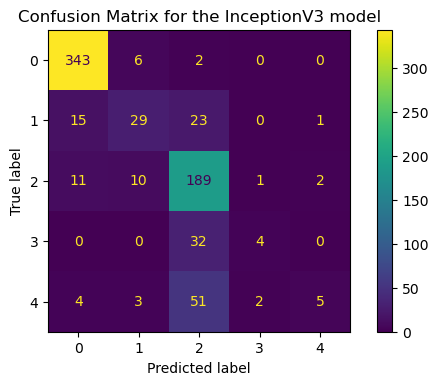

In [121]:
# confusion matrix
confusion_heatmap(ensemble_conf_matrix)

In [122]:
# weighted average specificity
ensemble_wa_specificity = weighted_average_specificity(ensemble_conf_matrix)
print(ensemble_wa_specificity)

[351, 68, 213, 36, 65]
0.8987808599454934


In [123]:
# macro avg specificity
ensemble_ma_specificity = macro_average_specificity(ensemble_conf_matrix)
print(inceptionResnet_ma_specificity)

0.9344111707389651


In [124]:
# micro_avg AUC
micro_avg_auc = micro_average_auc(mean_preds)
print("Ensembled model Micro-Average AUC:", micro_avg_auc)


Ensembled model Micro-Average AUC: 0.9099670300045026


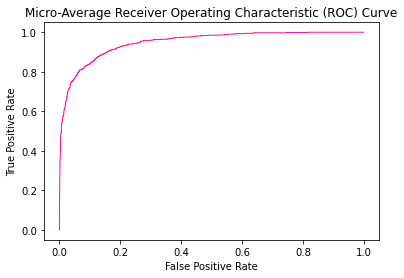

In [125]:
roc_plot(mean_preds)

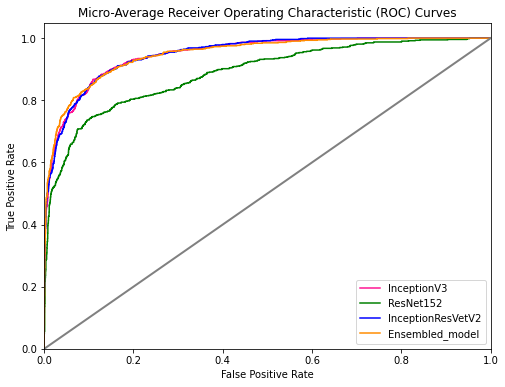

In [126]:
# Binarize actual test labels 
y_test_cat = label_binarize(y_test, classes=np.arange(num_classes))
# Compute the ROC curves and AUC scores for each model
fpr_inception, tpr_inception, _ = roc_curve(y_test_cat.ravel(), inceptionv3_y_pred.ravel())
fpr_resnet, tpr_resnet, _ = roc_curve(y_test_cat.ravel(), resnet152_y_pred.ravel())
fpr_inceptionResnet, tpr_inceptionResnet, _ = roc_curve(y_test_cat.ravel(), inceptionResnet_y_pred.ravel())
fpr_ensemble, tpr_ensemble, _ = roc_curve(y_test_cat.ravel(), mean_preds.ravel())

# Plot the ROC curves for each model
plt.figure(figsize=(8, 6))

plt.plot(fpr_inception, tpr_inception, color='deeppink', lw=1.5, label= 'InceptionV3')
plt.plot(fpr_resnet, tpr_resnet, color='green', lw=1.5, label= 'ResNet152')
plt.plot(fpr_inceptionResnet, tpr_inceptionResnet, color='blue', lw=1.5, label= 'InceptionResVetV2')
plt.plot(fpr_ensemble, tpr_ensemble, color='darkorange', lw=1.5, label= 'Ensembled_model')
 
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [127]:

ensemble_accuracy = accuracy_score(y_test, ensemble_prediction)

In [128]:
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

Accuracy Score for average ensemble =  0.7776261937244202
